In [ ]:
import nest_asyncio
import prompts
import importlib
import state 
import nodes 
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Dict, Any, Tuple, Literal

importlib.reload(prompts)
importlib.reload(state)
importlib.reload(nodes)
from nodes import assistant, HoneypotConfigurationNode, FirewallConfigurationNode, NetworkStatusNode, summarize_logs
from state import HoneypotStateReact
nest_asyncio.apply()



def display_graph(graph, width=250, height=300):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

In [ ]:
def route_message(state: HoneypotStateReact) -> Tuple[Literal["NetworkStatusNode", "FirewallConfigurationNode", "HoneypotConfigurationNode", "summarize", "__end__"], Dict[str, Any]]:
    # Check if we're in final response mode
    if hasattr(state, "tools_completed") and state.tools_completed:
        return END, {}
    
    if hasattr(state, "to_summarize") and state.to_summarize:
        return "summarize", {}

    message = state.messages[-1]

    # Initial tool calls processing
    if not hasattr(state, "pending_tool_calls") or not state.pending_tool_calls:
        if len(message.tool_calls) == 0:
            return END, {}
        pending_tool_calls = list(message.tool_calls)
    else:
        pending_tool_calls = state.pending_tool_calls

    # Process next tool call
    tool_call = pending_tool_calls.pop(0)

    # Determine next node based on tool call
    if tool_call['name'] == "getNetworkStatus":
        next_node = "NetworkStatusNode"
    elif tool_call['name'] == "getFirewallConfiguration":
        next_node = "FirewallConfigurationNode"
    elif tool_call['name'] == "getDockerContainers":
        next_node = "HoneypotConfigurationNode"
    else:
        raise ValueError(f"Unknown tool call: {tool_call['name']}")

    # Determine if all tools have been processed
    tools_completed = not pending_tool_calls

    # Return next node and updated state
    return next_node, {
        "pending_tool_calls": pending_tool_calls,
        "tools_completed": tools_completed
    }

In [ ]:

# Graph
builder = StateGraph(HoneypotStateReact)


def build_graph_react(builder: StateGraph):
    builder.add_node("assistant", assistant)
    builder.add_node("FirewallConfigurationNode", FirewallConfigurationNode)
    builder.add_node("NetworkStatusNode",NetworkStatusNode)
    builder.add_node("summarize", summarize_logs)
    builder.add_node("HoneypotConfigurationNode", HoneypotConfigurationNode)


    # Build the graph
    builder.add_edge(START, "assistant")
    builder.add_conditional_edges("assistant", route_message)
    builder.add_edge("FirewallConfigurationNode", "assistant")
    builder.add_edge("NetworkStatusNode", "assistant")
    builder.add_edge("HoneypotConfigurationNode", "assistant")
    builder.add_edge("summarize", "assistant")




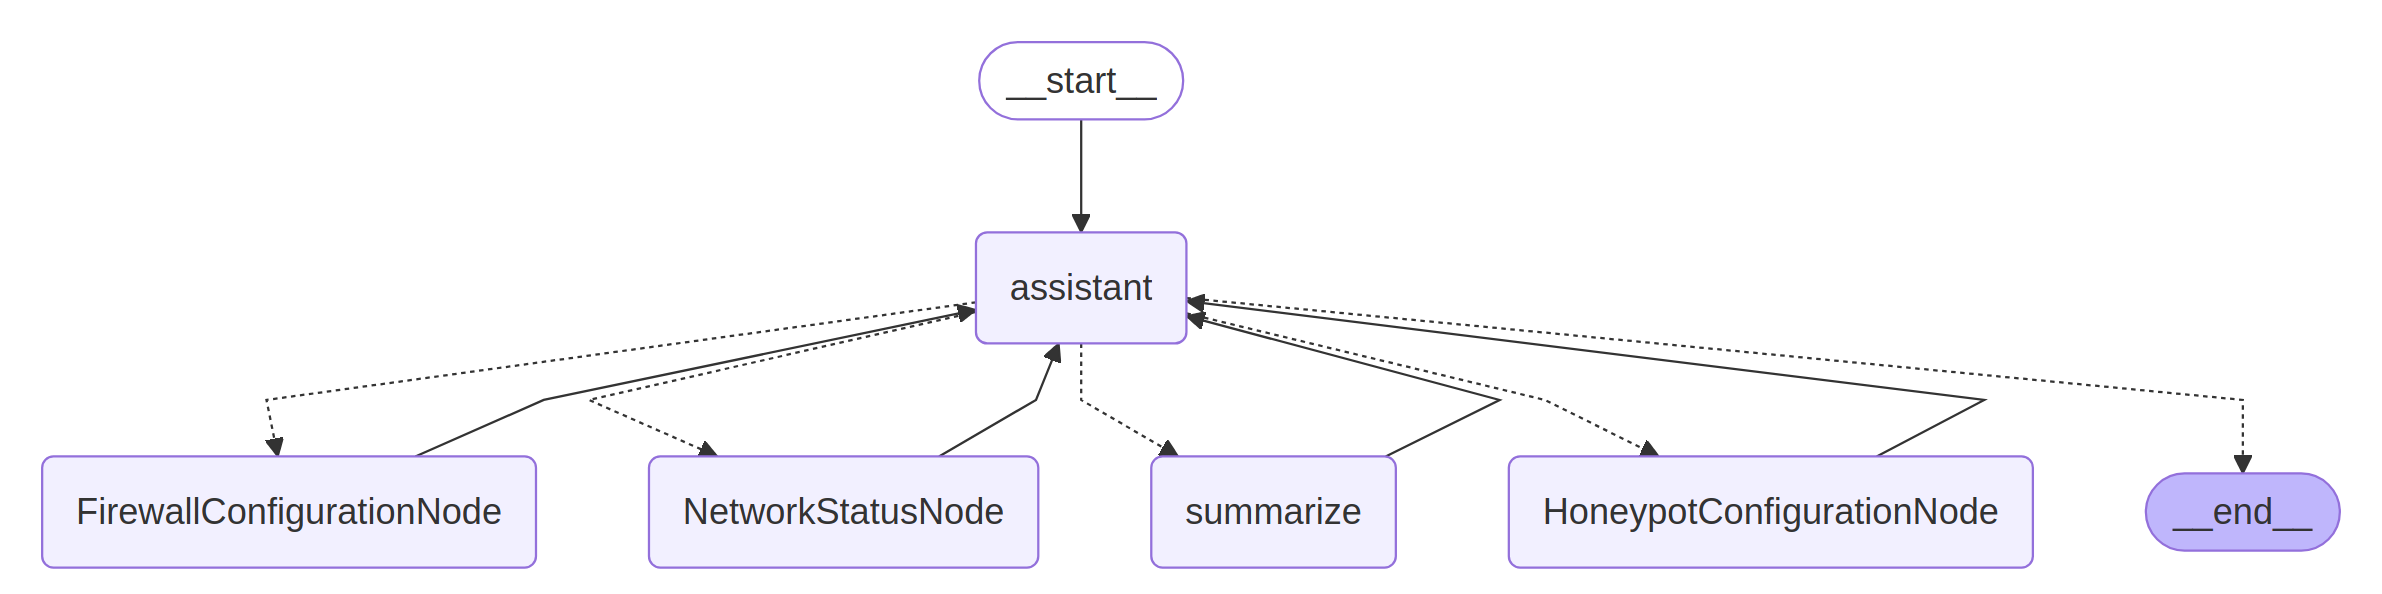

In [16]:
build_graph_react(builder)

graph = builder.compile()
display_graph(graph, width=500, height=500)

In [17]:
# Create an initial state
initial_state = HoneypotStateReact(
    messages = [],  
    network_logs = [],
    firewall_config= "No firewall configuration found",
    honeypotStatus = [],
    to_summarize = False,
    tools_completed = False
)

response = graph.invoke(initial_state)

Assistant node
Network node
Setting summarize flag
Assistant node
Summarizing node
Assistant node
Network node
Setting summarize flag
Assistant node
Summarizing node
Assistant node
Firewall node
Assistant node
Honeypot node
Assistant node
No tool calls or all tools completed


In [ ]:
for m in response['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  getNetworkStatus (call_r3qYtmvzbDGDN8gryPzuP3JL)
 Call ID: call_r3qYtmvzbDGDN8gryPzuP3JL
  Args:
    file_path: /home/c0ff3k1ll3r/Desktop/Thesis/AI_Agent_for_honeypot_operations/logsSSH/tshark_pcap/ssh_traffic.json
  getFirewallConfiguration (call_6hdcQZ1YDdo99RCZ528Jr34Z)
 Call ID: call_6hdcQZ1YDdo99RCZ528Jr34Z
  Args:
  getDockerContainers (call_YjFCh2yp0ZkXOjrBp8HxF8O5)
 Call ID: call_YjFCh2yp0ZkXOjrBp8HxF8O5
  Args:
================================== Ai Message ==================================
Tool Calls:
  getFirewallConfiguration (call_IZGSv0wwM7aOS71ps0nMhQTZ)
 Call ID: call_IZGSv0wwM7aOS71ps0nMhQTZ
  Args:
  getDockerContainers (call_wFbjhgdu9sNpofBoeeOqqFUa)
 Call ID: call_wFbjhgdu9sNpofBoeeOqqFUa
  Args:
================================== Ai Message ==================================
Tool Calls:
  getNetworkStatus (call_TMsDFrsT1cIWRo1lryyaelUG)
 Call ID: call_TMsDFrsT1cIWRo1lryya